In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator

from keras import models,layers,optimizers

import os

import warnings
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

Using TensorFlow backend.


In [2]:
# instantiate VGG16 model
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))


In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Approach 1
### Fast feature extraction without data augmentation

In [4]:
# Approach 1


base_dir = 'data/cats_and_dogs_small'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir,'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory,sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512 )) # last layer of VGG16
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                        target_size=(150,150),
                        batch_size=batch_size,
                        class_mode='binary')
    i = 0 
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i+=1
        if i*batch_size >= sample_count:
            break
    return features, labels

In [5]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir,1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
# reshape features for densely connected classifier
train_features = train_features.reshape(2000,4*4*512)
validation_features = validation_features.reshape(1000,4*4*512)
test_features = test_features.reshape(1000,4*4*512)

In [7]:
# Define densly connected classifier
model = models.Sequential()

model.add(layers.Dense(256,activation='relu',input_dim=4*4*512))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [9]:
history = model.fit(train_features,train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features,validation_labels))


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.5877 - acc: 0.6895 - val_loss: 0.4430 - val_acc: 0.8170
Epoch 2/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4251 - acc: 0.8065 - val_loss: 0.3646 - val_acc: 0.8490
Epoch 3/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3587 - acc: 0.8550 - val_loss: 0.3200 - val_acc: 0.8800
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3178 - acc: 0.8760 - val_loss: 0.2968 - val_acc: 0.8850
Epoch 5/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2911 - acc: 0.8800 - val_loss: 0.2864 - val_acc: 0.8930
Epoch 6/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2725 - acc: 0.8820 - val_loss: 0.2718 - val_acc: 0.8950
Epoch 7/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2447 - acc: 0.9045 - val_loss: 0.2715 - val_acc: 0.8900
Epoch 8/30
200

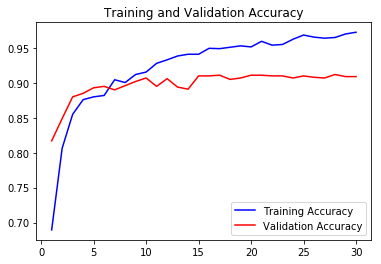

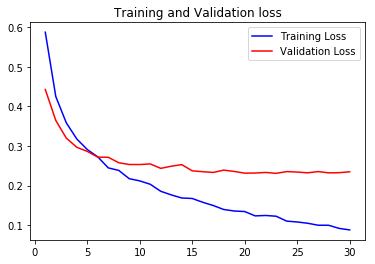

In [10]:
#  plot

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation loss')
plt.legend()

In [11]:
evaluation = model.evaluate(test_features,test_labels)
for i in range(2):
    print(model.metrics_names[i],':',evaluation[i])


1000/1000 [==============================] - 0s 261us/step
loss : 0.2573542425632477
acc : 0.883


### Approach 2
### Feature Extraction with Data Augmentation

In [12]:
# Add a densely connected classifier on top of convolutional base
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Freeze weights for conv_base
conv_base.trainable = False

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
# data preparation
# train_datagen = ImageDa

In [17]:
# data preparation
train_datagen = ImageDataGenerator(rescale=1./255,
                          rotation_range=40,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True,
                          fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                           target_size=(150,150),
                           batch_size=20,
                           class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                           target_size=(150,150),
                           batch_size=20,
                           class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [18]:
# model2.compile(loss='binary_crossentropy',
#                optimizer=optimizers.RMSprop(lr=2e-5),
#                metrics=['acc'])

# history2 = model2.fit_generator(train_generator,
#                                steps_per_epoch=100,
#                                epochs=30,
#                                validation_data=validation_generator,
#                                validation_steps=50)

Epoch 1/30
100/100 [==============================] - 408s 4s/step - loss: 0.5963 - acc: 0.6800 - val_loss: 0.4587 - val_acc: 0.8190
Epoch 2/30
100/100 [==============================] - 430s 4s/step - loss: 0.4918 - acc: 0.7790 - val_loss: 0.3750 - val_acc: 0.8630
Epoch 3/30
100/100 [==============================] - 422s 4s/step - loss: 0.4323 - acc: 0.8060 - val_loss: 0.3338 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 411s 4s/step - loss: 0.3990 - acc: 0.8240 - val_loss: 0.3122 - val_acc: 0.8740
Epoch 5/30
100/100 [==============================] - 396s 4s/step - loss: 0.3828 - acc: 0.8245 - val_loss: 0.2924 - val_acc: 0.8850
Epoch 6/30
100/100 [==============================] - 396s 4s/step - loss: 0.3815 - acc: 0.8265 - val_loss: 0.2835 - val_acc: 0.8910
Epoch 7/30
100/100 [==============================] - 396s 4s/step - loss: 0.3572 - acc: 0.8380 - val_loss: 0.2865 - val_acc: 0.8830
Epoch 8/30
100/100 [==============================] - 397s 4s/step - 

In [23]:
# # save model
# model2.save('models/cats_and_dog_VGG16_2.h5')
# # # save model training history
# pd.DataFrame(history2.history).to_csv('models/cats_and_dog_VGG16_2.csv',index=False)

In [25]:
# save model weights
model2.save_weights('models/cats_and_dog_VGG16_2_weights.h5')

# save model architecture
with open('models/cats_and_dog_VGG16_2_architecture.json','w') as f:
    f.write(model2.to_json())

In [ ]:
# # # Preferred way to load model
# load model architecture
with open('models/cats_and_dog_VGG16_2_architecture.json','r') as f:
    model2 = models.model_from_json(f.read())
    
# load weights into the model
model2.load_weights('models/cats_and_dog_VGG16_2_weights.h5')

In [ ]:
# # # load model
# model2 = models.load_model('models/cats_and_dog_VGG16_2.h5')
# # loading history data
history2 = pd.read_csv('models/cats_and_dog_VGG16_2.csv')

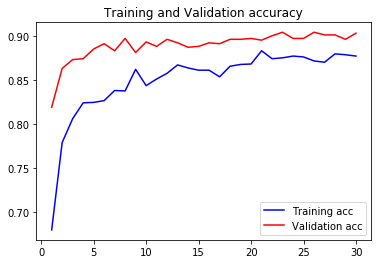

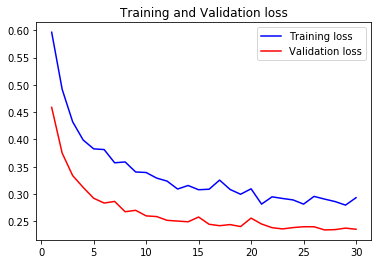

In [19]:
# plots
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend();

In [22]:
test_generator = test_datagen.flow_from_directory(test_dir,
                           target_size=(150,150),
                           batch_size=20,
                           class_mode='binary')

evaluation2 = model2.evaluate_generator(test_generator,
                          steps=50)

for i in range(2):
    print(model2.metrics_names[i],':',evaluation2[i])

Found 1000 images belonging to 2 classes.
loss : 0.24417253121733665
acc : 0.9009999954700469
